In [1]:
# Goal: Train an XGBoost classifier to predict heart disease using patient health metrics from the UCI Heart Disease dataset

In [2]:
import pandas as pd

# load the dataset
df = pd.read_csv('heart_disease_uci.csv')

# display the first few rows
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# preprocess the data

# check for null values
print(df.isnull().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [4]:
# to suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

In [5]:
# drop heavy gaps/irrelevant columns
df.drop(columns=['id', 'dataset', 'ca', 'thal', 'slope'], inplace=True, errors='ignore')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


In [6]:
# convert Target to Binary (0 and 1)
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


In [7]:
# fill Numeric gaps with Median
df.fillna(df.median(numeric_only=True), inplace=True)

In [8]:
# 4. Fill Categorical gaps with Mode
fill_values = {
    'fbs': df['fbs'].mode()[0],
    'restecg': df['restecg'].mode()[0],
    'exang': df['exang'].mode()[0]
}
df.fillna(value=fill_values, inplace=True)

In [9]:
# this turns 'sex', 'cp', etc., into types XGBoost can handle
for col in df.select_dtypes(['object']).columns:
    df[col] = df[col].astype('category')

In [10]:
print("Missing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64

Data types:
age            int64
sex         category
cp          category
trestbps     float64
chol         float64
fbs         category
restecg     category
thalch       float64
exang       category
oldpeak      float64
num            int64
dtype: object


In [11]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


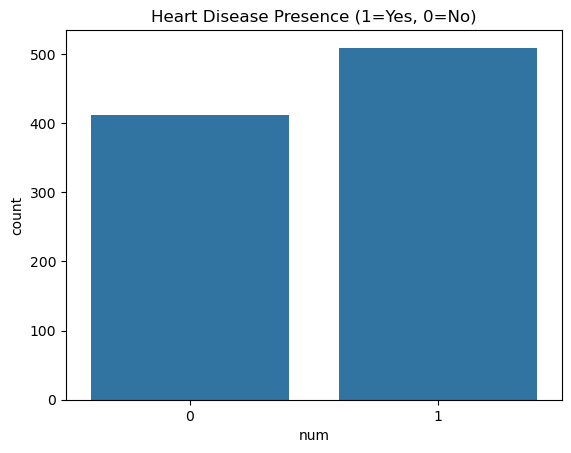

In [12]:
# class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='num', data=df)
plt.title("Heart Disease Presence (1=Yes, 0=No)")
plt.show()

In [13]:
# split into train and test sets
from sklearn.model_selection import train_test_split

In [14]:
# define features and target
X = df.drop('num', axis=1)
y = df['num']

# force all categorical features to be strings
for col in X.select_dtypes(['category']).columns:
    X[col] = X[col].astype(str).astype('category')

# train-test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# train XGBoost Model
from xgboost import XGBClassifier

# create and train XGBoost classifier
model = XGBClassifier(enable_categorical=True, tree_method='hist', eval_metric='logloss')
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,True
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [16]:
# make predictions and evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# predict on  test set
y_pred = model.predict(X_test)

# accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# detailed classification metrics
print("\n Classsfication Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8206521739130435

 Classsfication Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.80        75
           1       0.89      0.80      0.84       109

    accuracy                           0.82       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.82      0.82       184



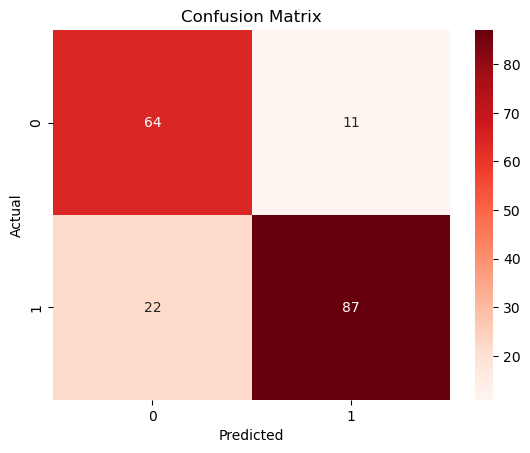

In [17]:
# confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

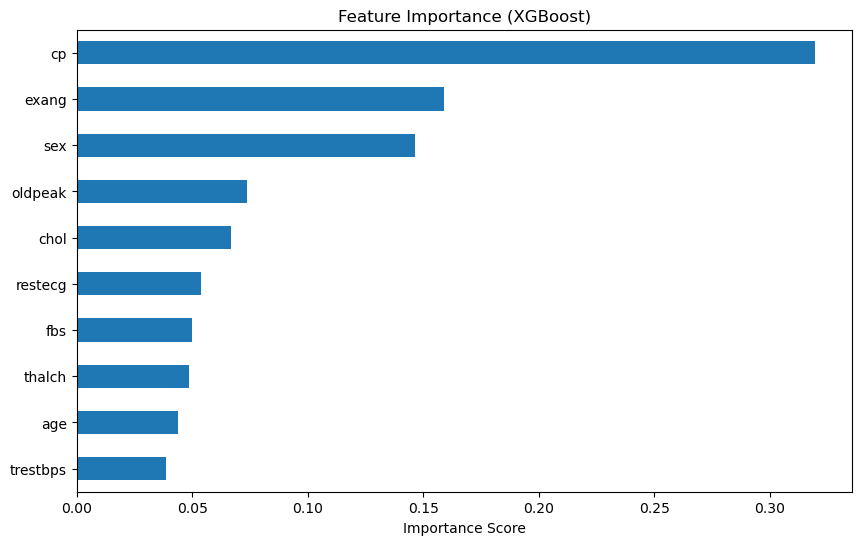

In [19]:
# feature importance visualization
plt.figure(figsize=(10, 6))
pd.Series(model.feature_importances_, index=X.columns).sort_values().plot(kind="barh")
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.show()